In [18]:
import numbers
import numpy as np
import cv2 as cv
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
import docplex
import docplex.mp.model
import control
import control.matlab

import utility as util

In [3]:
def get_vertices_from_centers_and_lws(centers, thetas, lws):
    C = np.cos(thetas)
    S = np.sin(thetas)
    rot11 = np.stack((-C,  S), axis=-1)
    rot12 = np.stack((-S, -C), axis=-1)
    rot21 = np.stack((-C, -S), axis=-1)
    rot22 = np.stack((-S,  C), axis=-1)
    rot31 = np.stack(( C, -S), axis=-1) 
    rot32 = np.stack(( S,  C), axis=-1)
    rot41 = np.stack(( C,  S), axis=-1)
    rot42 = np.stack(( S, -C), axis=-1)
    # Rot has shape (N, 8, 2)
    Rot = np.stack((rot11, rot12, rot21, rot22, rot31, rot32, rot41, rot42), axis=1)
    # disp has shape (N, 8)
    disp = 0.5 * np.einsum("...jk, ...k ->...j", Rot, lws)
    # centers has shape (N, 8)
    centers = np.tile(centers, (4,))
    return np.reshape(centers + disp, (-1,4,2))

def obj_matmul(A, B):
    """Non-vectorized multiplication of arrays of object dtype"""
    if len(B.shape) == 1:
        C = np.zeros((A.shape[0]), dtype=object)
        for i in range(A.shape[0]):
            for k in range(A.shape[1]):
                C[i] += A[i,k]*B[k]
    else:
        C = np.zeros((A.shape[0], B.shape[1]), dtype=object)
        for i in range(A.shape[0]):
            for j in range(B.shape[1]):
                for k in range(A.shape[1]):
                    C[i,j] += A[i,k]*B[k,j]
    return C

def obj_vectorize(f, A):
    if A.ndim == 0:
        return f(A)
    elif A.ndim == 1:
        return np.array([f(a) for a in A])
    else:
        return np.stack([obj_vectorize(f, a) for a in A])

def pairs2d_to_halfspace(p1, p2):
    """Get half-space representation dividing the left side and the right side
    of the line formed by two points in R^2. The points x where Ax <= b are on
    the right side of the arrow from p1 to p2.
    
     x_2
      ^
      |  \
      |   \  Ax > b
      |    p1
    --|-----\------> x_1
      |      p2
     Ax <= b  \
      |        \

    Parameters
    ==========
    p1 : ndarray
        First point
    p2 : ndarray
        Second point
    
    Returns
    =======
    np.array
        A where Ax <= b
    int
        b where Ax <= b
    
    """
    p11, p12 = p1
    p21, p22 = p2
    A = np.array([p12-p22, p21-p11])
    b = (p12 - p22)*p11 + (p21 - p11)*p12
    return A, b

def vertices_to_halfspace_representation(vertices):
    """Vertices of convex polytope to half-space representation (A, b).
    where points x, A x <= b are inside the polytope. 
    
    Parameters
    ==========
    vertices : np.array
        Vertices of convex polytope of shape (N, 2) where N is the number of vertices.
        The vertices are sorted in clockwise order along the first axis and N > 2.
        
    Returns
    =======
    np.array
        A where x, Ax <= b are the points of the polytope 
    np.array
        b where x, Ax <= b are the points of the polytope
    """
    vertices = np.concatenate((vertices, vertices[0][None],), axis=0)
    A = []; b = []
    for p1, p2 in util.pairwise(vertices):
        _A, _b = pairs2d_to_halfspace(p1, p2)
        A.append(_A); b.append(_b)
    A = np.stack(A); b = np.array(b)
    return A, b

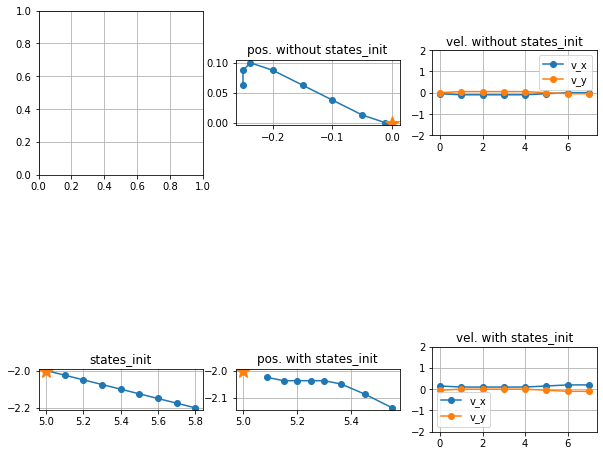

In [4]:
# Computing the states given state-space representation, and control inputs

Ts = 0.5
T = 8

# Heejin state-space representation.
A = np.diag([1, 1], k=2)
# B, sys.B both have shape (4, 2)
B = np.concatenate((np.diag([0,0]), np.diag([1,1]),))
# C has shape (2, 4)
C = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=1)
# D has shape (2, 2)
D = np.diag([0, 0])
sys = control.matlab.c2d(control.matlab.ss(A, B, C, D), Ts)

A = np.array(sys.A)
B = np.array(sys.B)
nx, nu = sys.B.shape

p_0_x, p_0_y, v_0_x, v_0_y = 5,-2,0.2,-0.05
x0 = np.array([p_0_x, p_0_y, v_0_x, v_0_y])

# Closed form solution to states given inputs
# C1 has shape (nx, T*nx)
C1 = np.zeros((nx, T*nx,))
# C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
C2 = np.kron(np.eye(T - 1), A)
# C3 has shape (nx*(T - 1), nx)
C3 = np.zeros(((T - 1)*nx, nx,))
# C, Abar have shape (nx*T, nx*T)
C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
Abar = np.eye(T * nx) - C
# Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
Bbar = np.kron(np.eye(T), B)
# Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
Gamma = np.concatenate((np.zeros((nx, T*nu,)), np.linalg.solve(Abar, Bbar),))

# make state computation account for initial position and velocity
states_init = np.concatenate([np.linalg.matrix_power(A, t) @ x0 for t in range(T+1)])
Z = states_init

u = np.array([
    [-0.1, 0], # 0
    [-0.1, 0.1], # 1
    [ 0, 0], # 2
    [ 0, 0], # 3
    [ 0, 0], # 4
    [ 0.1, -0.1],
    [ 0.1, -0.1],
    [ 0, 0], # 7
])
u = u.ravel()

# Gamma is used translate the sequence of controls
# into position and velocity over timesteps 1..T
X = Gamma @ u
x1 = X[nx::nx]
x2 = X[nx + 1::nx]
x3 = X[nx + 2::nx]
x4 = X[nx + 3::nx]

fig, axes = plt.subplots(2, 3, figsize=(10,10))
axes = axes.ravel()

# plot points without states_init
axes[1].plot(x1, x2, '-o')
axes[1].plot(0, 0, '*', markersize=15)
axes[2].plot(range(T), x3, '-o', label='v_x')
axes[2].plot(range(T), x4, '-o', label='v_y')

X = Z + Gamma @ u
x1 = X[nx::nx]
x2 = X[nx + 1::nx]
x3 = X[nx + 2::nx]
x4 = X[nx + 3::nx]
Z = Z.reshape((-1,4))

# plot points with states_init
axes[3].plot(Z[:,0], Z[:,1], '-o')
axes[3].plot(x0[0], x0[1], '*', markersize=15)
axes[4].plot(x1, x2, '-o')
axes[4].plot(x0[0], x0[1], '*', markersize=15)
axes[5].plot(range(T), x3, '-o', label='v_x')
axes[5].plot(range(T), x4, '-o', label='v_y')

axes[1].set_title('pos. without states_init')
axes[2].set_title('vel. without states_init')
axes[3].set_title('states_init')
axes[4].set_title('pos. with states_init')
axes[5].set_title('vel. with states_init')

axes[2].legend()
axes[2].set_ylim([-2,2])

axes[5].legend()
axes[5].set_ylim([-2,2])

for ax in axes:
    ax.set_aspect('equal')
    ax.grid()

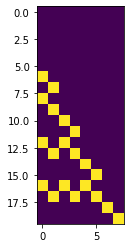

In [5]:
def get_state_space_mats(T):
    # Example of state space representation
    # https://en.wikipedia.org/wiki/State-space_representation
    # TODO: can we switch to something that's not a 2D matrix representation?

    # x1-2 -> position
    # x3-4 -> velocity
    # u1-2 -> velocity

    # x(k+1) = A x(k) + B u(k)
    # y(k) = C x(k)
    A = np.concatenate((np.diag([1,1]), np.diag([0,0]),), axis=0)
    A = np.concatenate((A, A,), axis=1)
    B = np.concatenate((np.diag([0,0]), np.diag([1,1]),), axis=0)

    # number of state variables x, number of input variables u
    # nx = 4, nu = 2
    nx, nu = B.shape
    # C1 has shape (nx, T*nx)
    C1 = np.zeros((nx, T*nx,))
    # C2 has shape (nx*(T - 1), nx*(T-1)) as A has shape (nx, nx)
    C2 = np.kron(np.eye(T - 1), A)
    # C3 has shape (nx*(T - 1), nx)
    C3 = np.zeros(((T - 1)*nx, nx,))
    # C, Abar have shape (nx*T, nx*T)
    C = np.concatenate((C1, np.concatenate((C2, C3,), axis=1),), axis=0)
    Abar = np.eye(T * nx) - C
    # Bbar has shape (nx*T, nu*T) as B has shape (nx, nu)
    Bbar = np.kron(np.eye(T), B)
    # Gamma has shape (nx*(T + 1), nu*T) as Abar\Bbar has shape (nx*T, nu*T)
    Gamma = np.concatenate((np.zeros((nx, T*nu,)),
            np.linalg.solve(Abar, Bbar),))
    return A, B, Gamma

A, B, Gamma = get_state_space_mats(4)
plt.imshow(Gamma)

Model: obstacle_avoidance
 - number of variables: 1260
   - binary=1200, integer=0, continuous=60
 - number of constraints: 1530
   - linear=1500, quadratic=30
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQCP


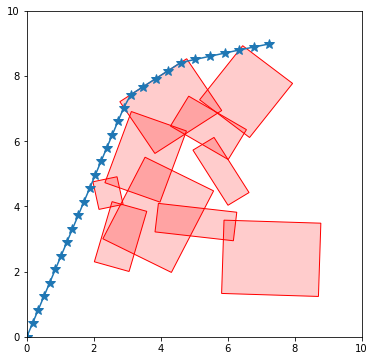

In [92]:
T = 30
A, B, Gamma = get_state_space_mats(T)
big_M = 1000
N = 10
S = 10.
S1 = 2.
S2 = 8.
max_scalar_velocity = 0.2
extent = np.array([[0, S],[0, S]])
# centers = np.random.uniform(low=(S1, S1), high=(S2, S2), size=(N,2))
sampler = scipy.stats.qmc.Halton(2)
centers = sampler.random(N)
centers = scipy.stats.qmc.scale(centers, (S1, S1), (S2, S2))
thetas  = np.random.uniform(low=-np.pi, high=np.pi, size=N)
lws = np.random.uniform(low=(0.5, 0.5), high=(3.0, 3.0), size=(N,2))
vertex_set = get_vertices_from_centers_and_lws(centers, thetas, lws)

As, bs = [], []
for vertices in vertex_set:
    _A, _b = vertices_to_halfspace_representation(vertices)
    As.append(_A); bs.append(_b)
# As has shape (N, 4, 2) and bs has shape (N, 4)
As = np.stack(As); bs = np.stack(bs)
    
fig, ax = plt.subplots(figsize=(6, 6))

for vertices in vertex_set:
    patch = patches.Polygon(vertices, fill=True, fc=(1, 0, 0, 0.2), color='r')
    ax.add_patch(patch)
ax.set_xlim(extent[0])
ax.set_ylim(extent[1])

model = docplex.mp.model.Model(name='obstacle_avoidance')
delta = np.array(model.binary_var_list(4*N*T, name='delta')).reshape(T, N, 4)

# TODO: fix Gamma shape
u = np.array(model.continuous_var_list(T*nu, lb=0., ub=S, name='control'))
for _u in u.reshape(-1, 2):
    model.add_constraint(_u[0]**2 + _u[1]**2 <= max_scalar_velocity)
x = obj_matmul(Gamma, u)
x = x.reshape(-1, 4)
X = x[:-1,:2]

for t in range(T):
    # for each timestep
    for n in range(N):
        A, b = As[n], bs[n]
        lhs = obj_matmul(A, X[t]) + big_M*(1 - delta[t,n])
        model.add_constraints([l >= r for (l,r) in zip(lhs, b)])
        model.add_constraint(np.sum(delta[t, n]) >= 1)

cost = (X[-1,0] - S)**2 + (x[-1,1] - S)**2
model.minimize(cost)
model.print_information()
s = model.solve()
# model.print_solution()

f = lambda x: x if isinstance(x, int) else x.solution_value
X = obj_vectorize(f, X)
X = X.T
ax.plot(X[0], X[1], '-*', markersize=10)
None

Model: obstacle_avoidance
 - number of variables: 288
   - binary=192, integer=0, continuous=96
 - number of constraints: 312
   - linear=264, quadratic=48
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQCP


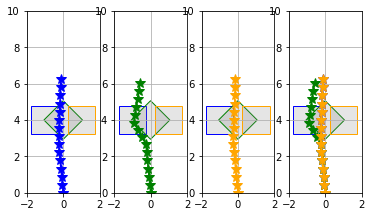

In [97]:
T = 16
A, B, Gamma = get_state_space_mats(T)
big_M = 1000
extent = np.array([[-2, 2],[0, 10]])

# create obstacles
height = 4
center1 = np.array([-1, height])
center2 = np.array([ 0, height])
center3 = np.array([ 1, height])
centers = np.stack((center1, center2, center3))
thetas = np.array([0,np.pi/4,0])
lw = np.array([1.5, 1.5])
lws = np.array([lw, lw, lw])
vertex_set = get_vertices_from_centers_and_lws(centers, thetas, lws)

# Set up half-spaces
As, bs = [], []
for vertices in vertex_set:
    _A, _b = vertices_to_halfspace_representation(vertices)
    As.append(_A); bs.append(_b)
# As has shape (N, 4, 2) and bs has shape (N, 4)
As = np.stack(As); bs = np.stack(bs)

model = docplex.mp.model.Model(name='obstacle_avoidance')
# TODO: fix Gamma shape
# set up controls variables for each trajectory
N_traj = vertex_set.shape[0]
N_coincide = 6
u = np.array(model.continuous_var_list(N_traj*T*nu, lb=-np.inf, ub=np.inf, name='control'))
delta = np.array(model.binary_var_list(4*N_traj*T, name='delta')).reshape(T, N_traj, 4)
for _u in u.reshape(-1, nu):
    model.add_constraint(_u[0]**2 + _u[1]**2 <= max_scalar_velocity)
U = u.reshape(N_traj, -1)

# set up position variables for each trajectory
X = []
for idx, u in enumerate(U): 
    x = obj_matmul(Gamma, u)
    x = x.reshape(-1, 4)
    X.append(x[:-1,:2])
# X has shape (T, N_traj, 2)
# TODO: the first 2 timesteps are numbers, not control variables
X = np.stack(X, axis=1)

# set up obstacle constraints
should_avoid_others = False
for t in range(T):
    # for each timestep
    for n in range(N_traj):
        # for each obstacle/trajectory
        if should_avoid_others:
            for _n in filter(lambda x: x != n, range(N_traj)):
                A, b = As[_n], bs[_n]
                lhs = obj_matmul(A, X[t,n]) + big_M*(1 - delta[t,_n])
                model.add_constraints([l >= r for (l,r) in zip(lhs, b)])
                model.add_constraint(np.sum(delta[t,_n]) >= 1)
        else:
            A, b = As[n], bs[n]
            lhs = obj_matmul(A, X[t,n]) + big_M*(1 - delta[t,n])
            model.add_constraints([l >= r for (l,r) in zip(lhs, b)])
            model.add_constraint(np.sum(delta[t,n]) >= 1)

# set up coinciding constraints
for t in range(2, N_coincide+2):
    for x1, x2 in util.pairwise(X[t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])
        
# set up cost
cost = 0
for n in range(N_traj):
    cost += (X[-1,n,0] - 0)**2 + (X[-1,n,1] - 10)**2
model.minimize(cost)
model.print_information()
s = model.solve()
# model.print_solution()

fig, axes = plt.subplots(1, N_traj + 1, figsize=(6, 6))
axes = axes.ravel()
COLORS = ('blue', 'green','orange')

for ax in axes:
    for idx, vertices in enumerate(vertex_set):
        
        patch = patches.Polygon(vertices,
                fill=True, fc=(0.5, 0.5, 0.5, 0.2), color=COLORS[idx])
        ax.add_patch(patch)

    ax.set_xlim(extent[0])
    ax.set_ylim(extent[1])
    ax.grid()
    ax.set_aspect('equal')

f = lambda x: x if isinstance(x, int) else x.solution_value
X = obj_vectorize(f, X)
X = X.transpose(1, 2, 0)
for n in range(N_traj):
    axes[N_traj].plot(X[n,0], X[n, 1], '-*', markersize=10, color=COLORS[n])
    axes[n].plot(X[n,0], X[n, 1], '-*', markersize=10, color=COLORS[n])


Model: obstacle_avoidance
 - number of variables: 1200
   - binary=960, integer=0, continuous=240
 - number of constraints: 1380
   - linear=1260, quadratic=120
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQCP


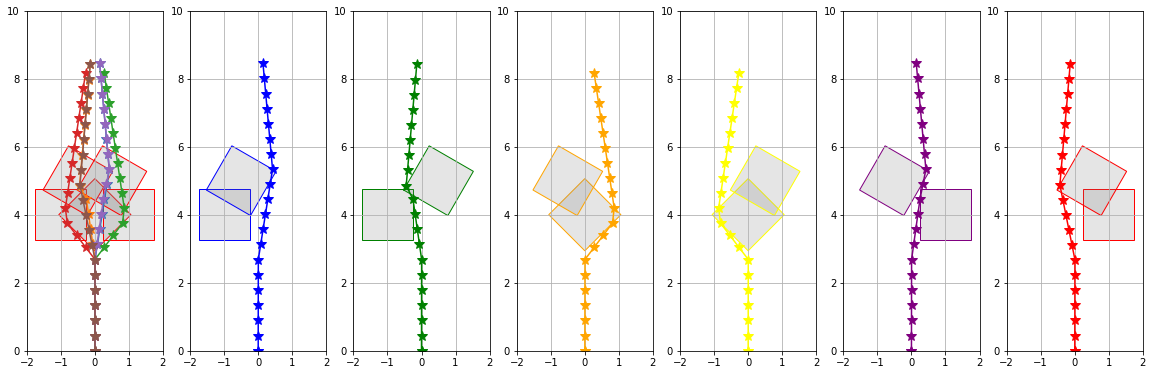

In [13]:
T = 20
A, B, Gamma = get_state_space_mats(T)
big_M = 1000
extent = np.array([[-2, 2],[0, 10]])
max_scalar_velocity = 0.2

# create obstacles
height1 = 4
height2 = 5
center1 = np.array([-1, height1])
center2 = np.array([ 0, height1])
center3 = np.array([ 1, height1])
center4 = np.array([-0.5, height2])
center5 = np.array([ 0.5, height2])
centers = np.stack((center1, center2, center3, center4, center5))
thetas = np.array([0,np.pi/4,0, np.pi/3, np.pi/3])
lw = np.array([1.5, 1.5])
lws = np.array([lw, lw, lw, lw, lw])
vertex_set = get_vertices_from_centers_and_lws(centers, thetas, lws)

N_traj = 6
# Set up half-spaces
As = [None]*N_traj
bs = [None]*N_traj
idx = 0
for vertices1 in vertex_set[:3]:
    _A1, _b1 = vertices_to_halfspace_representation(vertices1)
    for vertices2 in vertex_set[3:]:
        _As = []; _bs = []
        _As.append(_A1); _bs.append(_b1)
        _A2, _b2 = vertices_to_halfspace_representation(vertices2)
        _As.append(_A2); _bs.append(_b2)
        # As has shape (2, 4, 2) and bs has shape (2, 4)
        _As = np.stack(_As); _bs = np.stack(_bs)
        As[idx] = _As; bs[idx] = _bs
        idx += 1
        
model = docplex.mp.model.Model(name='obstacle_avoidance')
# TODO: fix Gamma shape
# set up controls variables for each trajectory
N_coincide = 6 # hardcode coincide
u = np.array(model.continuous_var_list(N_traj*T*nu, lb=-np.inf, ub=np.inf, name='control'))
delta = np.array(model.binary_var_list(2*4*N_traj*T, name='delta')).reshape(T, N_traj, 2, 4)
for _u in u.reshape(-1, nu):
    model.add_constraint(_u[0]**2 + _u[1]**2 <= max_scalar_velocity)
U = u.reshape(N_traj, -1)
X = obj_matmul(U, Gamma.T)
X = X.reshape(N_traj, -1, 4).swapaxes(0,1)
# X has shape (T, N_traj, 2)
# TODO: the first 2 timesteps are numbers, not control variables
X = X[...,:2]

# set up obstacle constraints
for t in range(T):
    # for each timestep
    for n in range(N_traj):
        # for each obstacle/trajectory
        _As = As[n]; _bs = bs[n]
        for idx, (A, b) in enumerate(zip(_As, _bs)):
            lhs = obj_matmul(A, X[t,n]) + big_M*(1 - delta[t,n,idx])
            model.add_constraints([l >= r for (l,r) in zip(lhs, b)])
            model.add_constraint(np.sum(delta[t,n,idx]) >= 1)

# set up coinciding constraints
for t in range(2, N_coincide+2):
    for x1, x2 in util.pairwise(X[t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])

# set up cost
cost = 0
for n in range(N_traj):
    cost += (X[-1,n,0] - 0)**2 + (X[-1,n,1] - 10)**2
model.minimize(cost)
model.print_information()
s = model.solve()
# model.print_solution()

fig, axes = plt.subplots(1, N_traj+1, figsize=(20, 10))
axes = axes.ravel()
COLORS = ('blue', 'green','orange','yellow','purple','red')

for idx, vertices in enumerate(vertex_set):
    patch = patches.Polygon(vertices,
            fill=True, fc=(0.5, 0.5, 0.5, 0.2), color='r')
    axes[0].add_patch(patch)

for ax in axes:
    ax.set_xlim(extent[0])
    ax.set_ylim(extent[1])
    ax.grid()
    ax.set_aspect('equal')

f = lambda x: x if isinstance(x, int) else x.solution_value
X = obj_vectorize(f, X)
X = X.transpose(1, 2, 0)
for n in range(N_traj):
    axes[0].plot(X[n,0], X[n, 1], '-*', markersize=10)
    
idx = 0
for vertices1 in vertex_set[:3]:
    for vertices2 in vertex_set[3:]:
        patch = patches.Polygon(vertices1,
                fill=True, fc=(0.5, 0.5, 0.5, 0.2), color=COLORS[idx])
        axes[idx+1].add_patch(patch)
        patch = patches.Polygon(vertices2,
                fill=True, fc=(0.5, 0.5, 0.5, 0.2), color=COLORS[idx])
        axes[idx+1].add_patch(patch)
        axes[idx+1].plot(X[idx,0], X[idx, 1], '-*', markersize=10, color=COLORS[idx])
        idx += 1

Modification of multiple coinciding controls

Model: obstacle_avoidance
 - number of variables: 1200
   - binary=960, integer=0, continuous=240
 - number of constraints: 1380
   - linear=1260, quadratic=120
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQCP


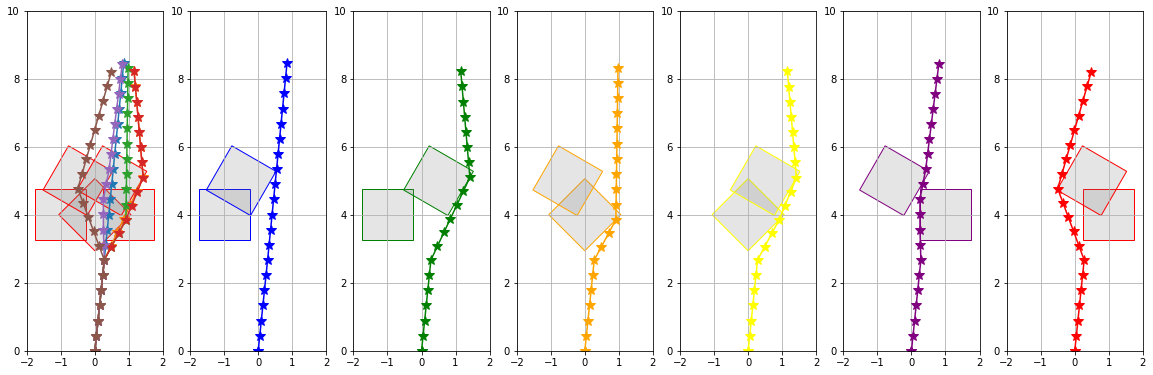

In [24]:
T = 20
A, B, Gamma = get_state_space_mats(T)
big_M = 1000
extent = np.array([[-2, 2],[0, 10]])
max_scalar_velocity = 0.2

# create obstacles
height1 = 4
height2 = 5
center1 = np.array([-1, height1])
center2 = np.array([ 0, height1])
center3 = np.array([ 1, height1])
center4 = np.array([-0.5, height2])
center5 = np.array([ 0.5, height2])
centers = np.stack((center1, center2, center3, center4, center5))
thetas = np.array([0,np.pi/4,0, np.pi/3, np.pi/3])
lw = np.array([1.5, 1.5])
lws = np.array([lw, lw, lw, lw, lw])
vertex_set = get_vertices_from_centers_and_lws(centers, thetas, lws)

N_traj = 6
# Set up half-spaces
As = [None]*N_traj
bs = [None]*N_traj
idx = 0
for vertices1 in vertex_set[:3]:
    _A1, _b1 = vertices_to_halfspace_representation(vertices1)
    for vertices2 in vertex_set[3:]:
        _As = []; _bs = []
        _As.append(_A1); _bs.append(_b1)
        _A2, _b2 = vertices_to_halfspace_representation(vertices2)
        _As.append(_A2); _bs.append(_b2)
        # As has shape (2, 4, 2) and bs has shape (2, 4)
        _As = np.stack(_As); _bs = np.stack(_bs)
        As[idx] = _As; bs[idx] = _bs
        idx += 1
        
model = docplex.mp.model.Model(name='obstacle_avoidance')
# set up controls variables for each trajectory
N_coincide = 6 # hardcode coincide
u = np.array(model.continuous_var_list(N_traj*T*nu, lb=-np.inf, ub=np.inf, name='control'))
delta = np.array(model.binary_var_list(2*4*N_traj*T, name='delta')).reshape(N_traj, T, 2, 4)
for _u in u.reshape(-1, nu):
    model.add_constraint(_u[0]**2 + _u[1]**2 <= max_scalar_velocity)
U = u.reshape(N_traj, -1)
X = obj_matmul(U, Gamma.T)
X = X.reshape(N_traj, -1, 4)
# X has shape (N_traj, T, 2)
# TODO: the first 2 timesteps are numbers, not control variables
X = X[...,:2]

# set up obstacle constraints
for t in range(T):
    # for each timestep
    for n in range(N_traj):
        # for each obstacle/trajectory
        _As = As[n]; _bs = bs[n]
        for idx, (A, b) in enumerate(zip(_As, _bs)):
            lhs = obj_matmul(A, X[n,t]) + big_M*(1 - delta[n,t,idx])
            model.add_constraints([l >= r for (l,r) in zip(lhs, b)])
            model.add_constraint(np.sum(delta[n,t,idx]) >= 1)

# set up coinciding constraints
for t in range(2, N_coincide+2):
    for x1, x2 in util.pairwise(X[:,t]):
        model.add_constraints([l == r for (l,r) in zip(x1, x2)])

# set up cost
goal = np.array([1, 10])
cost = np.sum((X[:,-1] - goal)**2)

# solve problem
model.minimize(cost)
model.print_information()
s = model.solve()
# model.print_solution()

fig, axes = plt.subplots(1, N_traj+1, figsize=(20, 10))
axes = axes.ravel()
COLORS = ('blue', 'green','orange','yellow','purple','red')

for idx, vertices in enumerate(vertex_set):
    patch = patches.Polygon(vertices,
            fill=True, fc=(0.5, 0.5, 0.5, 0.2), color='r')
    axes[0].add_patch(patch)

for ax in axes:
    ax.set_xlim(extent[0])
    ax.set_ylim(extent[1])
    ax.grid()
    ax.set_aspect('equal')

f = lambda x: x if isinstance(x, numbers.Number) else x.solution_value
X = obj_vectorize(f, X)
for n in range(N_traj):
    axes[0].plot(X[n,:,0], X[n,:,1], '-*', markersize=10)
idx = 0
for vertices1 in vertex_set[:3]:
    for vertices2 in vertex_set[3:]:
        patch = patches.Polygon(vertices1,
                fill=True, fc=(0.5, 0.5, 0.5, 0.2), color=COLORS[idx])
        axes[idx+1].add_patch(patch)
        patch = patches.Polygon(vertices2,
                fill=True, fc=(0.5, 0.5, 0.5, 0.2), color=COLORS[idx])
        axes[idx+1].add_patch(patch)
        axes[idx+1].plot(X[idx,:,0], X[idx,:,1], '-*', markersize=10, color=COLORS[idx])
        idx += 1

In [7]:
# Warm starting in CPLEX
# Based on:
# https://stackoverflow.com/questions/66860193/warm-start-in-cplex-python

mdl = docplex.mp.model.Model(name='buses')
nbbus40 = mdl.integer_var(name='nbBus40')
nbbus30 = mdl.integer_var(name='nbBus30')
mdl.add_constraint(nbbus40*40 + nbbus30*30 >= 300, 'kids')
mdl.minimize(nbbus40*500 + nbbus30*400)

warmstart=mdl.new_solution()
warmstart.add_var_value(nbbus40,8)
warmstart.add_var_value(nbbus30,0)
mdl.add_mip_start(warmstart)

sol=mdl.solve(log_output=True)

for v in mdl.iter_integer_vars():
    print(v," = ",v.solution_value)

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 4000.0000.
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 0 columns.
MIP Presolve added 1 rows and 1 columns.
MIP Presolve modified 1 coefficients.
Reduced MIP has 1 rows, 3 columns, and 3 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1 rows and 1 columns.
MIP Presolve added 1 rows and 1 columns.
Reduced MIP has 1 rows, 3 columns, and 3 nonzeros.
Reduced MIP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.00 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 12 threads.
Root relaxation solution time = 0.00 sec. (0.00 ticks)

        Nodes          